# **RESUME CLASSIFICATION PROJECT**


---

This project involves classification of Resumes into 25 categories. 
The data is has been taken from multiple sources and it is also freely available on kaggle. The raw dataset has also been uploaded.

The project can be summarised as follows:

 - A quick EDA on the data
 - Method 1: TF-IDF/Count Vectoriser for the data representation and Random Forest and Extra Trees for the classification
 - Method 2: Importing GloVe and using the pre - trained word embeddings for the data represetation. Random Forest is used for the classification
 - Method 3: Using skip-grams and negative sampling to create word embeddings similar to those in word2vec. Use those word embeddings for data representation and Tree-Based algorithms for classification.  
 - Method 4: Create an LSTM using Keras and use it to classify the Resumes.



# Method 1: TF-IDF/Counr Vectorizer   

In [0]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from wordcloud import WordCloud
from sklearn import metrics

In [7]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
data_resume_path = '/content/gdrive/My Drive/NLP_adv/glove/UpdatedResumeDataSet.csv'

In [0]:
data = pd.read_csv(data_resume_path)

In [10]:
data.head()

,Category,Resume
0,Data Science,Skills * Programming Languages: Python (pandas...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...
2,Data Science,"Areas of Interest Deep Learning, Control Syste..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab..."


In [11]:
# Unique categories in the Category column 
print(data["Category"].unique())

['Data Science' 'HR' 'Advocate' 'Arts' 'Web Designing'
 'Mechanical Engineer' 'Sales' 'Health and fitness' 'Civil Engineer'
 'Java Developer' 'Business Analyst' 'SAP Developer' 'Automation Testing'
 'Electrical Engineering' 'Operations Manager' 'Python Developer'
 'DevOps Engineer' 'Network Security Engineer' 'PMO' 'Database' 'Hadoop'
 'ETL Developer' 'DotNet Developer' 'Blockchain' 'Testing']


In [12]:
# Total number of times each category has occured
data["Category"].value_counts(dropna = False)

Java Developer               84
Testing                      70
DevOps Engineer              55
Python Developer             48
Web Designing                45
HR                           44
Hadoop                       42
Sales                        40
Data Science                 40
Operations Manager           40
ETL Developer                40
Mechanical Engineer          40
Blockchain                   40
Arts                         36
Database                     33
PMO                          30
Electrical Engineering       30
Health and fitness           30
DotNet Developer             28
Business Analyst             28
Automation Testing           26
Network Security Engineer    25
Civil Engineer               24
SAP Developer                24
Advocate                     20
Name: Category, dtype: int64

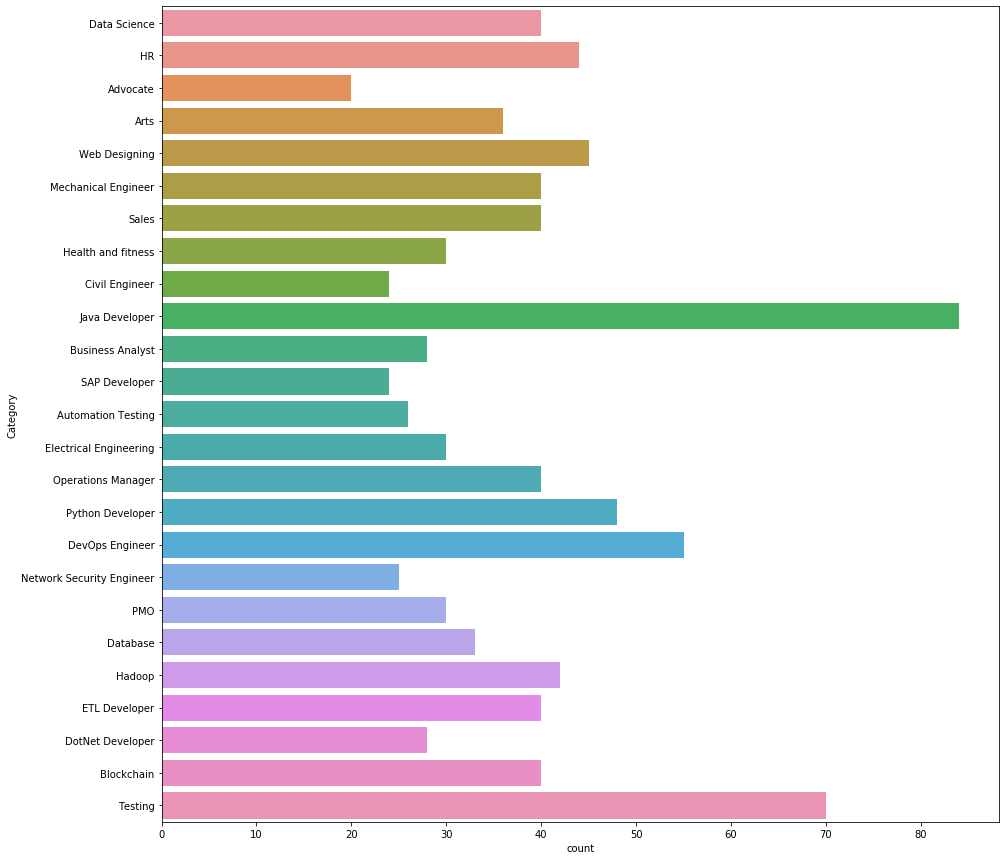

In [13]:
import seaborn as sns 
# Ploting the unique counts using a countplot from seaborn
#plt.figsize((12,8))
plt.figure(figsize=(15,15))
sns.countplot(y="Category", data=data)

In [0]:
targetNames = data["Category"].unique()

The function **cleanResume** uses regular expressions to remove anything that is unnecessary in the text such as:
  - URLs
  - RTs and cc's
  - hashtags
  - mentions
  - punctuations
  - extra whitespaces

In [0]:
import re
def cleanResume(resumeText):
    resumeText = re.sub('http\S+\s*', ' ', resumeText)  # remove URLs
    resumeText = re.sub('RT|cc', ' ', resumeText)  # remove RT and cc
    resumeText = re.sub('#\S+', '', resumeText)  # remove hashtags
    resumeText = re.sub('@\S+', '  ', resumeText)  # remove mentions
    resumeText = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""), ' ', resumeText)  # remove punctuations
    resumeText = re.sub(r'[^\x00-\x7f]',r' ', resumeText) 
    resumeText = re.sub('\s+', ' ', resumeText)  # remove extra whitespace
    return resumeText

In [0]:
# make a copy of the data
data_cleaned_act = data

In [0]:
# Applying the fuction cleanResume
data_cleaned_act["Resume_cls"] = data["Resume"].apply(lambda x:cleanResume(x))

In [0]:
# Drop the Resume column as it is no longer necessary 
data_cleaned_act.drop(columns="Resume",inplace=True)

In [19]:
# Visualise the data
data_cleaned_act.head()

,Category,Resume_cls
0,Data Science,Skills Programming Languages Python pandas num...
1,Data Science,Education Details May 2013 to May 2017 B E UIT...
2,Data Science,Areas of Interest Deep Learning Control System...
3,Data Science,Skills R Python SAP HANA Tableau SAP HANA SQL ...
4,Data Science,Education Details MCA YMCAUST Faridabad Haryan...


In [0]:
# import the preprocessing module from sklearn in order to encode the different categories
from sklearn import preprocessing

In [0]:
# Initialise the label encoder
le = preprocessing.LabelEncoder()

In [0]:
# encode the Category column
trans = le.fit_transform(data_cleaned_act["Category"])
#trans = le.transform(data_cleaned_act["Category"])

In [0]:
data_cleaned_act["act_labels"] = trans

In [24]:
data_cleaned_act.head(10)

,Category,Resume_cls,act_labels
0,Data Science,Skills Programming Languages Python pandas num...,6
1,Data Science,Education Details May 2013 to May 2017 B E UIT...,6
2,Data Science,Areas of Interest Deep Learning Control System...,6
3,Data Science,Skills R Python SAP HANA Tableau SAP HANA SQL ...,6
4,Data Science,Education Details MCA YMCAUST Faridabad Haryan...,6
5,Data Science,SKILLS C Basics IOT Python MATLAB Data Science...,6
6,Data Science,Skills Python Tableau Data Visualization R Stu...,6
7,Data Science,Education Details B Tech Rayat and Bahra Insti...,6
8,Data Science,Personal Skills Ability to quickly grasp techn...,6
9,Data Science,Expertise Data and Quantitative Analysis Decis...,6


In [25]:
# Encoded labels
data_cleaned_act["act_labels"]

0       6
1       6
2       6
3       6
4       6
       ..
957    23
958    23
959    23
960    23
961    23
Name: act_labels, Length: 962, dtype: int64

In [26]:
Y = data_cleaned_act["act_labels"].as_matrix()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [0]:
count_vect = CountVectorizer(decode_error='ignore')
tiidf_vect = TfidfVectorizer(decode_error='ignore')

In [0]:
X_cv = count_vect.fit_transform(data_cleaned_act["Resume_cls"])
X_tfidf = tiidf_vect.fit_transform(data_cleaned_act["Resume_cls"])

In [0]:
Xtrain,Xtest,Ytrain,Ytest = train_test_split(X_cv,Y,test_size=0.33)

In [30]:
model = MultinomialNB()
model.fit(Xtrain,Ytrain)
print("train score",model.score(Xtrain,Ytrain))
print("test score",model.score(Xtest,Ytest))

train score 0.9984472049689441
test score 0.9779874213836478


In [0]:
predictions = model.predict(Xtest)

In [32]:
print(metrics.accuracy_score(Ytest,predictions))

0.9779874213836478


In [33]:
print(metrics.classification_report(Ytest,predictions))

              precision    recall  f1-score   support

           0       1.00      0.60      0.75         5
           1       0.87      1.00      0.93        13
           2       1.00      1.00      1.00         8
           3       1.00      1.00      1.00        15
           4       1.00      1.00      1.00         4
           5       1.00      1.00      1.00         9
           6       1.00      1.00      1.00        11
           7       1.00      1.00      1.00        12
           8       1.00      0.89      0.94        18
           9       1.00      0.79      0.88        14
          10       1.00      1.00      1.00        10
          11       1.00      1.00      1.00        12
          12       1.00      1.00      1.00        12
          13       1.00      1.00      1.00        19
          14       1.00      1.00      1.00         6
          15       0.90      1.00      0.95        27
          16       1.00      1.00      1.00        13
          17       1.00    

In [0]:
def visualise(label):
    # labels is a class. One of the 24 classes 
    
    words = ''
    for resume in data_cleaned_act[data_cleaned_act['Category'] == label]["Resume_cls"]:
        #resume is the whole Resume
        
        resume = resume.lower()
        words += resume + ' '
    wordcloud = WordCloud(width=600,height=400).generate(words)
    print(wordcloud.words_)
    print("++++++++++++++++++++++++++++++++++")
    print(wordcloud.stopwords)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.figure(figsize=(15,15))
    plt.show()    

{'exprience less': 1.0, 'less year': 1.0, 'data science': 0.9743589743589743, 'machine learning': 0.9230769230769231, 'year months': 0.8205128205128205, 'exprience months': 0.5128205128205128, 'data': 0.41025641025641024, 'deep learning': 0.3333333333333333, 'education details': 0.2564102564102564, 'skill details': 0.2564102564102564, 'monthscompany details': 0.2564102564102564, 'details company': 0.2564102564102564, 'sap hana': 0.23076923076923078, 'technical environment': 0.23076923076923078, 'python exprience': 0.20512820512820512, 'learning exprience': 0.20512820512820512, 'months python': 0.1794871794871795, 'year monthscompany': 0.1794871794871795, 'key responsibilities': 0.1794871794871795, 'neural network': 0.1794871794871795, 'learning deep': 0.1794871794871795, 'analytic': 0.15384615384615385, 'sentiment analysis': 0.15384615384615385, 'months machine': 0.15384615384615385, 'consultant months': 0.15384615384615385, 'aegis school': 0.15384615384615385, 'school data': 0.1538461

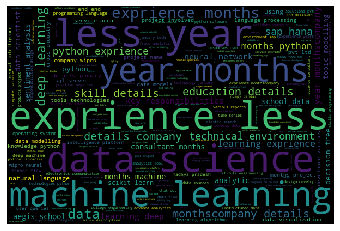

<Figure size 1080x1080 with 0 Axes>

In [35]:
visualise("Data Science")

Example code of words that make the algorithm make a wrong prediction.

In [0]:
# Predictions on the entire dataset 
data_cleaned_act["Preds"] = model.predict(X_cv)

In [0]:
#mistakes_0_class_res - represents pandas series containing the rows as well as the content (words) that the algorithm
#classifies incorrectly. 

# Usefull for further analysis!


mistakes_0_class_res = data_cleaned_act[(data_cleaned_act["Preds"] != 0) & (data_cleaned_act["act_labels"] == 0)]["Resume_cls"]

In [0]:
msg = ''
for words in mistakes_0_class_res:
    words.lower()
    msg += words + ' '

In [39]:
msg

' Hard working Quick learnerEducation Details June 2014 to May 2017 LLB LAW Mumbai Maharashtra mumbai university January 2014 B Com Commerce Mumbai Maharashtra Mumbai university January 2011 HSC Maharashtra board January 2009 SSC Maharashtra board Advocate Skill Details Company Details company The vidishtra description   Hard working Quick learnerEducation Details June 2014 to May 2017 LLB LAW Mumbai Maharashtra mumbai university January 2014 B Com Commerce Mumbai Maharashtra Mumbai university January 2011 HSC Maharashtra board January 2009 SSC Maharashtra board Advocate Skill Details Company Details company The vidishtra description  '

In [40]:
mistakes_0_class_res


93      Hard working Quick learnerEducation Details J...
103     Hard working Quick learnerEducation Details J...
Name: Resume_cls, dtype: object

# Conclusion
Despite the fact that TF-IDF/Count Vectorizer models do not take grammar or relationship between words into account, the model presented in this chapter produces very high accuracy despite its simplicity.

#  Method 2: Classification using pretrained weights from Glove

This section is focused on using weights from **GloVe** to classify each Resume.
**GloVe** is a pre-trained vector representation of words, trained by researchers from Stanford at a very large scale. **GloVe** has several different variation depending on the size of each vector representing each word. For this example, the smallest vector size will be used which is a lenght of 50.
Overall **GloVe's** main advantage is the fact that it considers word order, unlike Bag Of Words algorithm which does not.   

In [0]:
# Path to the glove file 
glove_path = '/content/gdrive/My Drive/NLP_adv/glove/glove.6B.50d.txt'

In [39]:
print('Loading test vectors')
word2vec = {}
embeddings = []
idx2word = []
with open(glove_path) as f:
  for line in f:
    values = line.split()
    word = values[0]
    w_embedings = np.asarray(values[1:], dtype='float32')

    word2vec[word] = w_embedings
    embeddings.append(w_embedings)
    idx2word.append(word)
print('Found %s word vectors.' % len(word2vec))

Loading test vectors
Found 400000 word vectors.


In [40]:
# Visualising the word2vec dictionary
word2vec

{'the': array([ 4.1800e-01,  2.4968e-01, -4.1242e-01,  1.2170e-01,  3.4527e-01,
        -4.4457e-02, -4.9688e-01, -1.7862e-01, -6.6023e-04, -6.5660e-01,
         2.7843e-01, -1.4767e-01, -5.5677e-01,  1.4658e-01, -9.5095e-03,
         1.1658e-02,  1.0204e-01, -1.2792e-01, -8.4430e-01, -1.2181e-01,
        -1.6801e-02, -3.3279e-01, -1.5520e-01, -2.3131e-01, -1.9181e-01,
        -1.8823e+00, -7.6746e-01,  9.9051e-02, -4.2125e-01, -1.9526e-01,
         4.0071e+00, -1.8594e-01, -5.2287e-01, -3.1681e-01,  5.9213e-04,
         7.4449e-03,  1.7778e-01, -1.5897e-01,  1.2041e-02, -5.4223e-02,
        -2.9871e-01, -1.5749e-01, -3.4758e-01, -4.5637e-02, -4.4251e-01,
         1.8785e-01,  2.7849e-03, -1.8411e-01, -1.1514e-01, -7.8581e-01],
       dtype=float32),
 ',': array([ 0.013441,  0.23682 , -0.16899 ,  0.40951 ,  0.63812 ,  0.47709 ,
        -0.42852 , -0.55641 , -0.364   , -0.23938 ,  0.13001 , -0.063734,
        -0.39575 , -0.48162 ,  0.23291 ,  0.090201, -0.13324 ,  0.078639,
        -0.4

In [41]:
# Visualising the first 10 embeddings
embeddings[:10]

[array([ 4.1800e-01,  2.4968e-01, -4.1242e-01,  1.2170e-01,  3.4527e-01,
        -4.4457e-02, -4.9688e-01, -1.7862e-01, -6.6023e-04, -6.5660e-01,
         2.7843e-01, -1.4767e-01, -5.5677e-01,  1.4658e-01, -9.5095e-03,
         1.1658e-02,  1.0204e-01, -1.2792e-01, -8.4430e-01, -1.2181e-01,
        -1.6801e-02, -3.3279e-01, -1.5520e-01, -2.3131e-01, -1.9181e-01,
        -1.8823e+00, -7.6746e-01,  9.9051e-02, -4.2125e-01, -1.9526e-01,
         4.0071e+00, -1.8594e-01, -5.2287e-01, -3.1681e-01,  5.9213e-04,
         7.4449e-03,  1.7778e-01, -1.5897e-01,  1.2041e-02, -5.4223e-02,
        -2.9871e-01, -1.5749e-01, -3.4758e-01, -4.5637e-02, -4.4251e-01,
         1.8785e-01,  2.7849e-03, -1.8411e-01, -1.1514e-01, -7.8581e-01],
       dtype=float32),
 array([ 0.013441,  0.23682 , -0.16899 ,  0.40951 ,  0.63812 ,  0.47709 ,
        -0.42852 , -0.55641 , -0.364   , -0.23938 ,  0.13001 , -0.063734,
        -0.39575 , -0.48162 ,  0.23291 ,  0.090201, -0.13324 ,  0.078639,
        -0.41634 , -0.15

In [0]:
#Setting up the data and the targets for GloVe
X_glove = data_cleaned_act.Resume_cls
Y_glove = data_cleaned_act.act_labels

In [0]:
#Performing a train - test split
X_glove_train,X_glove_test,Y_glove_train,Y_glove_test = train_test_split(X_glove,Y_glove,test_size=0.33)

In [0]:
# Path to the glove file 
glove_path = '/content/gdrive/My Drive/NLP_adv/glove/glove.6B.50d.txt'

In [0]:
# Imports
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from gensim.models import KeyedVectors

The Glove class has an inrface has been designed to have an interface very similar to that of a SkLearn model.
In the Initialiser method, the glove directory is accessed and the file is opened and read. We then obtain word_vec_dictinary which contains all the words in glove and their respective embeddings, lst_embds containing all embeddings from glove and word_idxs containing all the words.
The fit method is then initialised which takes the data set and returns or does nothing. It only serves to mimic the SkLearn interface.
The transform method goes through the data and substitutes each word of each sentence with its corresponding embedding vector from glove. It then finds the mean of all word embeddings accross the columns. 

In [0]:
class Glove:
  def __init__(self):
    # load in pre-trained word vectors
    print('Loading word vectors...')

    word_vec_dict = {}
    lst_of_embds = []
    word_idxs = []
    with open(glove_path) as f:
      for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype='float32')
        word_vec_dict[word] = vec
        lst_of_embds.append(vec)
        word_idxs.append(word)
    print('Found %s word vectors.' % len(word_vec_dict))
    self.word_vec_dict = word_vec_dict
    self.lst_of_embds = np.array(lst_of_embds)
    self.word2idx = {v:k for k,v in enumerate(word_idxs)}
    self.V, self.D = self.lst_of_embds.shape

  def fit(self, data):
    pass

  def transform(self, data):
    X = np.zeros((len(data), self.D))
    n = 0
    emptycount = 0
    for sentence in data:
      #print(sentence)
      tokens = sentence.lower().split()
      #print("Lenght of Tokens is: ",len(tokens))
      #print("tokens are: ",tokens)
      all_vectors = []
      for word in tokens:
        #print("word is: ",word)
        if word in self.word_vec_dict:
          single_vec = self.word_vec_dict[word]
          #print("single_vec is: ",single_vec)
          all_vectors.append(single_vec)
          #print("#######################################")
          #print("all_vectors is: ",all_vectors)
      if len(all_vectors) > 0:
        all_vectors = np.array(all_vectors)
        #print("all_vectors after np array are now: ",all_vectors)
        X[n] = all_vectors.mean(axis=0)
        #print("X is: ",X)
        #print("X[n] is: ",X[n])
      else:
        emptycount += 1
      n += 1
    print("Numer of samples containing no words found: %s / %s" % (emptycount, len(data)))
    return X

  def fit_transform(self, data):
    self.fit(data)
    return self.transform(data)

For this part of the project, two classifiers from SkLearn will be used - Random Forest and Extra Trees.


In [49]:
vectorizer = Glove()
# vectorizer = Word2VecVectorizer()
Xtrain = vectorizer.fit_transform(X_glove_train)
Ytrain = Y_glove_train

Xtest = vectorizer.transform(X_glove_test)
Ytest = Y_glove_test



# create the model, train it, print scores
model = RandomForestClassifier(n_estimators=200)
model.fit(Xtrain, Ytrain)
print("train score:", model.score(Xtrain, Ytrain))
print("test score:", model.score(Xtest, Ytest))

Loading word vectors...
Found 400000 word vectors.
Numer of samples containing no words found: 0 / 644
Numer of samples containing no words found: 0 / 318
train score: 1.0
test score: 0.9779874213836478


In [50]:
# Extra trees classifier
params = {'n_estimators':100,
          'criterion':'gini',
          'min_samples_leaf':1,
          'max_features':'auto'
          }
model = ExtraTreesClassifier(**params)
model.fit(Xtrain, Ytrain)
print("train score:", model.score(Xtrain, Ytrain))
print("test score:", model.score(Xtest, Ytest))
predictions = model.predict(Xtest)
print(metrics.classification_report(Ytest,predictions))

train score: 1.0
test score: 0.9779874213836478
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         8
           2       1.00      0.78      0.88         9
           3       1.00      1.00      1.00         9
           4       1.00      0.75      0.86        16
           5       1.00      1.00      1.00         6
           6       0.85      1.00      0.92        11
           7       1.00      1.00      1.00         7
           8       1.00      0.93      0.96        14
           9       1.00      1.00      1.00         8
          10       1.00      1.00      1.00        10
          11       1.00      1.00      1.00         9
          12       1.00      1.00      1.00        17
          13       1.00      1.00      1.00        19
          14       1.00      1.00      1.00        10
          15       1.00      1.00      1.00        35
          16       0.89      1.00

The two classifiers both produce very high and identical overall accuracy scores. 

# Method 3: Deriving a word2vec from the Resume Dataset
In this subsection, Word2Vec embeddings will be derived. 
The method that will be used will be skip-grams and negative sampling.

The link below can be used to obtain a diagram of a skip-gram.
The sentence which has been outlined is: "The yellow car crashed into the tree".
https://drive.google.com/open?id=1-0KZLsDpFt01ycCSH5WsOgCWQe70ZeMj

The idea behind a skip-gram is that given a middle word as an input we try to predict the words around it. From the diagram shown in the link above we can see that given the input word "car" we try to find the conditional probability that given the input word "car" what is the probability the words "the","yellow","crashed" and "into". Essentially we have a standart neural network for multiclass classification, the main difference is that there is no activation function between the input and the hidden layer.   

The value at the hidden layer then is equal to:
h = W1[input] which is a D sized vector

The output probability then becomes:
P(y|input) = softmax((W2.T).dot(h)).


The weight matrixes W1 and W2 will be updated through stochastic gradient descent. The function in the code is: **stoch_grad_descent**.

Negative sampling is also used to reduce the number of samples we train on.

The functions used in the code are:
 - sentences_wordidx_dic - which goes through each word within each 





In [51]:
# Visualising the data
data_cleaned_act.Resume_cls

0      Skills Programming Languages Python pandas num...
1      Education Details May 2013 to May 2017 B E UIT...
2      Areas of Interest Deep Learning Control System...
3      Skills R Python SAP HANA Tableau SAP HANA SQL ...
4      Education Details MCA YMCAUST Faridabad Haryan...
                             ...                        
957    Computer Skills Proficient in MS office Word B...
958     Willingness to a ept the challenges Positive ...
959    PERSONAL SKILLS Quick learner Eagerness to lea...
960    COMPUTER SKILLS SOFTWARE KNOWLEDGE MS Power Po...
961    Skill Set OS Windows XP 7 8 8 1 10 Database MY...
Name: Resume_cls, Length: 962, dtype: object

In [0]:
data_cleaned_act.act_labels

0       6
1       6
2       6
3       6
4       6
       ..
957    23
958    23
959    23
960    23
961    23
Name: act_labels, Length: 962, dtype: int64

In [0]:
# get the Resume data into data_wvec and the labels to labels_wvec
data_w2vec = data_cleaned_act.Resume_cls
labels_w2vec = data_cleaned_act.act_labels

The **sentences_wordidx_dic** function returns a list of lists of unique indexes, each unique index corresponding to a unique word and a dictionary consisting of each unique word as a key and an index as a value.
The function starts by looping through each word in each sentence in the Resumes. A dictionary called word_counts is created containing each word as a key and the number of times each word appears as a count.
The wordidx_dic dictionary is then created by using enumerate on a sorted word_counts. A second loop is then used to go over the Resumes again and extract each index from the wordidx_dic dictionary. The sentences and the wordidx_dic dictionary are then returned.

In [0]:
def sentences_wordidx_dic():
  V = 7550
  sents = []
  word_counts = {} # contains a word and its count
  wordidx_dic = {}

  for line in data_w2vec:
    if len(line) > 0:
      tokens = line.lower().split()
      for word in tokens:
        if word not in word_counts:
          word_counts[word] = 0
        word_counts[word] +=1
  sorted_word_counts = sorted(word_counts.items(),key=lambda x:x[1],reverse=True)
  print("Done")
  #V = min(V,len(word_counts))

  #total_words = [w for w,count in words_sorted[:V]]
  #total_words = words_sorted
  print(len(sorted_word_counts))


  #word2idx = {w:i for i,w in enumerate(words_sorted)}
  #word2idx = {w:i for i,w in enumerate(total_words)}
  #enumerate returns key pairs of index and key

  
  wordidx_dic = {w:i for i,w in enumerate(word_counts)} # contains word and an index 
  print("Second Loop")

  for row in data_w2vec:
    if len(row) > 0:
      sep_words = row.lower().split()
      single_sent = [wordidx_dic[w] for w in sep_words] # gives indexes in a single sentence
    sents.append(single_sent)
  

  return sents,wordidx_dic

The **neg_sampling** returns the negative sampling distribution from which we sample to  obtain the negative samples.

In [0]:
def neg_sampling(sentences, vocab_size):
  # Pn(w) = prob of word occuring
  # we would like to sample the negative samples
  # such that words that occur more often
  # should be sampled more often

  word_freq = np.zeros(vocab_size)
  word_count = sum(len(sentence) for sentence in sentences)
  for sentence in sentences:
      for word in sentence:
          word_freq[word] += 1

  neg_prob = (word_freq**0.75)/(word_freq**0.75).sum()
  # smooth it
  #p_neg = word_freq**0.75

  # normalize it
  #p_neg = p_neg / p_neg.sum()

  assert(np.all(neg_prob > 0))
  return neg_prob

In [0]:
# Testing sentences_wordidx_dic()
sentences,wordidx_dic = sentences_wordidx_dic()

Done
7601
Second Loop


In [0]:
# Size of the vocabulary
vocab_size = vocab_size = len(wordidx_dic)

In [0]:
# Obtain negative probability distribution
probs = neg_sampling(sentences,vocab_size)

In [0]:
probs

array([1.56061994e-03, 5.85402117e-04, 5.78555248e-04, ...,
       5.12866635e-05, 5.12866635e-05, 5.12866635e-05])

In [0]:
#probs = get_negative_sampling_distribution(sentences,vocab_size)

In [0]:
probs

array([1.56061994e-03, 5.85402117e-04, 5.78555248e-04, ...,
       5.12866635e-05, 5.12866635e-05, 5.12866635e-05])

In [0]:
def skip_gram_true_context(pos, sentence, window_size):
 
  start = max(0, pos - window_size)
  end_  = min(len(sentence), pos + window_size)

  skip_gram_output_context = []
  for skip_pos, word_idx in enumerate(sentence[start:end_], start=start):
    if skip_pos != pos:
      skip_gram_output_context.append(word_idx)
  return skip_gram_output_context

The **stoch_grad_descent** performs stochastic gradient descent to update the two weight metrixes. W1 is of size VxD and W2 is of size DxV where V is the vocabulary size and D is the size of the each embedding vector. The skip-gram approach is used where the middle word is the input and the predictions are its surrounding words

In [0]:
def stoch_grad_descent(input_, targets, label, learning_rate, W1, W2):
 
  output_prob = sigmoid(W1[input_].dot(W2[:,targets]))
  # gradients
  gW2 = np.outer(W1[input_], output_prob - label) 
  gW1 = np.sum((output_prob - label)*W2[:,targets], axis=1) 

  W2[:,targets] -= learning_rate*gW2 
  W1[input_] -= learning_rate*gW1 

  cost = label * np.log(output_prob + 1e-10) + (1 - label) * np.log(1 - output_prob + 1e-10) # cost function for binary cross entropy
  return cost.sum()

In [0]:
def word_to_vec_model_train(savedir):
  # get the data
  sentences, word2idx = sentences_wordidx_dic() #get_brown()


  # number of unique words
  vocab_size = len(word2idx)


  # config
  window_size = 5#how many surrounding words we are going to predict
  learning_rate = 0.025
  final_learning_rate = 0.0001
  num_negatives = 5 # number of negative samples to draw per input word
  epochs = 20
  D = 50 # word embedding size


  # learning rate decay
  learning_rate_delta = (learning_rate - final_learning_rate) / epochs


  # Weight Matrixes in the skip-gram
  W1 = np.random.randn(vocab_size, D) # input-to-hidden
  W2 = np.random.randn(D, vocab_size) # hidden-to-output


  # Negative Sample Distribution
  p_neg = neg_sampling(sentences, vocab_size)


  # A list to hold all the cost
  # Usefull to ensure that the cost is decreasing for each iteration
  costs = []


  # Number of total words
  total_words = sum(len(sentence) for sentence in sentences)
  print("total number of words in corpus:", total_words)

  # Subsampling distribution
  threshold = 1e-5 # standart value for the threshold
  p_drop = 1 - np.sqrt(threshold / p_neg)


  # train the model
  for epoch in range(epochs):
    # randomly order sentences so we don't always see
    # sentences in the same order
    np.random.shuffle(sentences)

    # accumulate the cost
    cost = 0
    counter = 0
    t0 = datetime.now()
    for sentence in sentences:
      # Words are being droped based on the subsampling distribution
      sentence = [w for w in sentence \
        if np.random.random() < (1 - p_drop[w])
      ]
      if len(sentence) < 2:
        continue


      # randomises the word order
      randomly_ordered_positions = np.random.choice(
        len(sentence),
        size=len(sentence),
        replace=False,
      )

      # For each possition in the random possitions obtain
      # the actual word 
      for pos in randomly_ordered_positions:
        word = sentence[pos]
        
        skip_gram_context_words = skip_gram_true_context(pos, sentence, window_size)
        neg_sampled_word = np.random.choice(vocab_size, p=p_neg)
        targets = np.array(skip_gram_context_words)

        # perform stochastic grad descent for a contexual word and a negative
        # word. The label changes between 0 and 1 depending on whether the word is 
        # contexual or negative
        c = stoch_grad_descent(word, targets, 1, learning_rate, W1, W2)
        cost += c
        c = stoch_grad_descent(neg_sampled_word, targets, 0, learning_rate, W1, W2)
        cost += c

      counter += 1
      if counter % 100 == 0:
        sys.stdout.write("processed %s / %s\r" % (counter, len(sentences)))
        sys.stdout.flush()
        


    # Output the cost at each epoch
    dt = datetime.now() - t0
    print("NUmber of epochs secessfully completed:", epoch, "Total cost:", cost, "Time:", dt)

    # Append the cost to the total list of costs.
    costs.append(cost)

    # update the learning rate
    learning_rate -= learning_rate_delta


  # After looping over the epochs has been completed, plot the gathered costs
  # It is expected that the cost will be decreasing per iteration
  plt.plot(costs)
  plt.show()


  # save the model
  if not os.path.exists(savedir):
    os.mkdir(savedir)

  with open('%s/word2idx_real2.json' % savedir, 'w') as f:
    json.dump(word2idx, f)

  np.savez('%s/weights_real2.npz' % savedir, W1, W2)

  # return the model
  return word2idx, W1, W2


In [0]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit as sigmoid
from sklearn.utils import shuffle
from datetime import datetime
# from util import find_analogies

from scipy.spatial.distance import cosine as cos_dist
from sklearn.metrics.pairwise import pairwise_distances

In [0]:
dir = "/content/gdrive/My Drive/NLP_adv"

Done
7601
Second Loop
total number of words in corpus: 412242
epoch complete: 0 cost: -2080417.4513326641 dt: 0:00:20.276647
epoch complete: 1 cost: -1337825.2145914442 dt: 0:00:20.545005
epoch complete: 2 cost: -1087883.7925485543 dt: 0:00:20.399265
epoch complete: 3 cost: -978870.8279356859 dt: 0:00:20.463782
epoch complete: 4 cost: -907613.9141857132 dt: 0:00:20.625189
epoch complete: 5 cost: -862232.3551801858 dt: 0:00:20.597663
epoch complete: 6 cost: -835966.9123226118 dt: 0:00:20.433946
epoch complete: 7 cost: -807165.3091662242 dt: 0:00:20.417893
epoch complete: 8 cost: -792172.5368010179 dt: 0:00:20.503551
epoch complete: 9 cost: -777878.9530961068 dt: 0:00:20.516562
epoch complete: 10 cost: -766400.548884251 dt: 0:00:20.478169
epoch complete: 11 cost: -748549.1173835476 dt: 0:00:20.427334
epoch complete: 12 cost: -741004.4862009548 dt: 0:00:20.271091
epoch complete: 13 cost: -734375.6792659628 dt: 0:00:20.346901
epoch complete: 14 cost: -726082.2095136187 dt: 0:00:20.366640
e

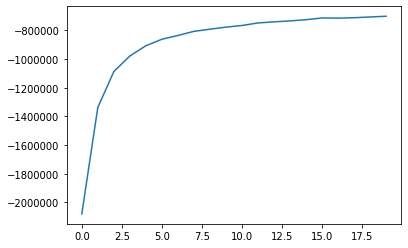

({'skills': 0,
  'programming': 1,
  'languages': 2,
  'python': 3,
  'pandas': 4,
  'numpy': 5,
  'scipy': 6,
  'scikit': 7,
  'learn': 8,
  'matplotlib': 9,
  'sql': 10,
  'java': 11,
  'javascript': 12,
  'jquery': 13,
  'machine': 14,
  'learning': 15,
  'regression': 16,
  'svm': 17,
  'na': 18,
  've': 19,
  'bayes': 20,
  'knn': 21,
  'random': 22,
  'forest': 23,
  'decision': 24,
  'trees': 25,
  'boosting': 26,
  'techniques': 27,
  'cluster': 28,
  'analysis': 29,
  'word': 30,
  'embedding': 31,
  'sentiment': 32,
  'natural': 33,
  'language': 34,
  'processing': 35,
  'dimensionality': 36,
  'reduction': 37,
  'topic': 38,
  'modelling': 39,
  'lda': 40,
  'nmf': 41,
  'pca': 42,
  'neural': 43,
  'nets': 44,
  'database': 45,
  'visualizations': 46,
  'mysql': 47,
  'sqlserver': 48,
  'cassandra': 49,
  'hbase': 50,
  'elasticsearch': 51,
  'd3': 52,
  'js': 53,
  'dc': 54,
  'plotly': 55,
  'kibana': 56,
  'ggplot': 57,
  'tableau': 58,
  'others': 59,
  'regular': 60,


In [0]:
# Training the Model
word_to_vec_model_train(dir)

# Conclusion
The cost has been decreasing as expected.
The shape of the curve is also as expected.
It can be observed that the cost decreasees for every iteration

Loading the New Word2Vec model i.e the one that was just produced and testing it on the Resumes Data Set. 
We can re-use some of the Glove code previously written. 
We will use the Random Forest algorithm from SkLearn to verify the correct operation of the algorithm.

In [0]:
def load_model(savedir):
  with open('%s/word2idx_real2.json' % savedir) as f:
    word2idx = json.load(f)
  npz = np.load('%s/weights_real2.npz' % savedir)
  W1 = npz['arr_0']
  W2 = npz['arr_1']
  return word2idx, W1, W2

In [0]:
word2idx,W1,W2 = load_model(dir)

The function **word_to_vec** takes in the word2idx dictionary containing each word in our corpus and its corresponding index and the weight matrix W1. It is also possible to take advantage of both W1 and W2 and combine them into one.

In [0]:
def word_to_vec(word2idx,W1):
  words = [w for w,i in word2idx.items()]
  new_word_vecs = dict(zip(words,W1))
  return new_word_vecs

In [0]:
new_word_vecs = word_to_vec(word2idx,W1)

In [0]:
new_word_vecs

{'skills': array([ 0.29344473, -0.27541557, -0.24219741,  0.18484447, -0.08999079,
        -0.01091005, -0.10038377,  0.30226273,  0.1960989 , -0.17310675,
        -0.27006797,  0.05509729,  0.35088658,  0.39492327, -0.2954101 ,
        -0.08161888,  0.2356042 ,  0.26727872,  0.18580905, -0.29008445,
        -0.05479311,  0.29868966, -0.39859679,  0.03490768,  0.16444505,
        -0.34782115,  0.13287962,  0.00596366, -0.30982288, -0.14442193,
         0.0329723 , -0.03332988, -0.26606751, -0.17095093, -0.42335024,
         0.12200323,  0.46218024,  0.14290056,  0.17980721,  0.40107377,
         0.00484244, -0.03935578,  0.29359507, -0.14988474,  0.07746459,
         0.03501534, -0.04671352, -0.27098524,  0.19226343,  0.2386692 ]),
 'programming': array([ 0.13617491, -0.03238629, -0.12875579, -0.0426303 , -0.04987631,
         0.03600418,  0.0490138 ,  0.29629219, -0.01375875, -0.06779483,
        -0.18085136, -0.04323409, -0.03570986,  0.48414797, -0.36710254,
         0.05198133, -0.

In [0]:
X_my_glove = data_cleaned_act.Resume_cls
Y_my_glove = data_cleaned_act.act_labels

In [0]:
X_myglove_train,X_myglove_test,Y_myglove_train,Y_myglove_test = train_test_split(X_my_glove,Y_my_glove,test_size=0.33)

The **transform_new** function takes the Resumes data and for each word it finds its corresponding word embedding vector with the new_word_vecs which now contains word embeddings produced with the skip-grams and negative sampling approach demonstrated above.

In [0]:
def transform_new(data):
    X = np.zeros((len(data),50))
    n = 0
    emptycount = 0
    for sentence in data:
      tokens = sentence.lower().split()
      vecs = []
      for word in tokens:
        if word in new_word_vecs:
          vec = new_word_vecs[word]
          vecs = np.append(vecs,vec)
      if len(vecs) > 0:
        vecs = np.array(vecs)
        X[n] = vecs.mean(axis=0)
      else:
        emptycount += 1
      n += 1
    print("Numer of samples with no words found: %s / %s" % (emptycount, len(data)))
    return X

Run Random Forest Classifier on the data

In [0]:
Xtrain = transform_new(X_myglove_train)
Ytrain = Y_myglove_train

Xtest = transform_new(X_myglove_test)
Ytest = Y_myglove_test

model = RandomForestClassifier(n_estimators=200)
model.fit(Xtrain, Ytrain)
print("train score:", model.score(Xtrain, Ytrain))
print("test score:", model.score(Xtest, Ytest))

Numer of samples with no words found: 0 / 644
Numer of samples with no words found: 0 / 318
train score: 1.0
test score: 0.9779874213836478


# Final Conclussion

We can see that the performance of the Random Forest Classifier is fairly close to the performance of the classification algorithms when using GloVe.

Some improvements such as combining both embedding matrixes W1 and W2 and using CBOW instead of skip-grams. 

# Method 4: Classification of Resumes Using LSTMs with Keras

This section presents another  approach to Resumes Classification using Long Short-Term Memory(LSTM). For this section Keras will be used to create the Model.

In [0]:
 # Initialising the data and the targets
X_rnn = data_cleaned_act.Resume_cls
Y_rnn = data_cleaned_act.act_labels

In [0]:
X_rnn

0      Skills Programming Languages Python pandas num...
1      Education Details May 2013 to May 2017 B E UIT...
2      Areas of Interest Deep Learning Control System...
3      Skills R Python SAP HANA Tableau SAP HANA SQL ...
4      Education Details MCA YMCAUST Faridabad Haryan...
                             ...                        
957    Computer Skills Proficient in MS office Word B...
958     Willingness to a ept the challenges Positive ...
959    PERSONAL SKILLS Quick learner Eagerness to lea...
960    COMPUTER SKILLS SOFTWARE KNOWLEDGE MS Power Po...
961    Skill Set OS Windows XP 7 8 8 1 10 Database MY...
Name: Resume_cls, Length: 962, dtype: object

In [0]:
Y_rnn

0       6
1       6
2       6
3       6
4       6
       ..
957    23
958    23
959    23
960    23
961    23
Name: act_labels, Length: 962, dtype: int64

In [1]:
# Importing Tensorflow 2.0 and outputing the tensorflow's verion 
try:
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)

TensorFlow 2.x selected.
2.1.0-rc1


In [0]:
# Preprocessing Imports
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [0]:
# Keras Imports
from tensorflow.keras.layers import Input,Dense,GlobalMaxPooling1D
from tensorflow.keras.layers import LSTM,Embedding
from tensorflow.keras.models import Model

In [0]:
X_rnn = data_cleaned_act.Resume_cls
Y_rnn = data_cleaned_act.act_labels

In [0]:
# Performing train and test split
X_rnn_train,X_rnn_test,Y_rnn_train,Y_rnn_test = train_test_split(X_rnn,Y_rnn.values,test_size=0.33)

After performing the train and test split, we initialise the tokenizer and fit it on the our training data which is in the form of resumes. The tokenisation process involves assigning a unique integer to each word. thus turning it into a sequence.

In [0]:
MAX_VOCAB_SIZE = 7600
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(X_rnn_train)
train_seq = tokenizer.texts_to_sequences(X_rnn_train)
test_seq = tokenizer.texts_to_sequences(X_rnn_test)

In [0]:
# word2idx is a dictionary containing all the words in the corpus and their unique
# integers 
word2idx = tokenizer.word_index

In [0]:
# Total number of words - 7544
V = len(word2idx)

In [50]:
len(word2idx)

7544

After the sequences have been generated by the tokeniser, padding needs to be applied to ensure that all sequences are of the same length. After padding we obtain an NxT array where N is the number of samples and T is the number of time steps. In this case we have pre-padding. 

In [0]:
data_train = pad_sequences(train_seq)

In [52]:
len(data_train)

644

In [53]:
data_train.shape

(644, 2064)

In [0]:
T = data_train.shape[1] # length of the sequences

In [0]:
data_test = pad_sequences(test_seq,maxlen=T)

In [56]:
print("Shape of the test data: ",data_test.shape)

Shape of the test data:  (318, 2064)


In this model, the LSTM layer also takes in a second parameter in addition to the size of the hidden layer M, called return_sequences.
Tipically, an RNN goes through the entire sequence and returns only the final hidden state i.e h(T) where h is the value of at the hidden layer and T is the lenght of the sequence i.e the sequnce goes from 1,2....T. In this the RNN returns a vector of size M.

If the return_sequences is set to True the RNN returns all the hidden states i.e it returns an array of size TxM. 
We can now use GlobalMaxPool1D which takes in a 2 dimentional array of size TxM and collapsees the first dimention so the output is a vector of size M.



In [0]:
# Create the model

# Embeding dimentinality
D = 20

# Hidden layer dimentionality 
M = 15

i = Input(shape = (T,))#sequence of integers of size T
x = Embedding(V + 1,D)(i)#takes in sequences of integers and returns sequences of word vectors. This is an array of size NxTxD.
x = LSTM(M,return_sequences=True)(x)# Actual LSTM layer.Outputs a TxM matrix
x = GlobalMaxPooling1D()(x)#output is M
x = Dense(25,activation='softmax')(x)# K outputs where K is equal to 25 since we have 25 classes.

model = Model(i,x)

In [58]:
model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

print("Training Model")

r = model.fit(data_train,
              Y_rnn_train,
              epochs = 30,
              validation_data = (data_test,Y_rnn_test))


Training Model
Train on 644 samples, validate on 318 samples
Epoch 1/30
644/644 [==============================] - 25s 40ms/sample - loss: 3.2085 - accuracy: 0.0901 - val_loss: 3.1933 - val_accuracy: 0.1006
Epoch 2/30
644/644 [==============================] - 23s 36ms/sample - loss: 3.1810 - accuracy: 0.1102 - val_loss: 3.1605 - val_accuracy: 0.1038
Epoch 3/30
644/644 [==============================] - 24s 37ms/sample - loss: 3.1365 - accuracy: 0.1273 - val_loss: 3.0807 - val_accuracy: 0.0912
Epoch 4/30
644/644 [==============================] - 23s 36ms/sample - loss: 3.0275 - accuracy: 0.1661 - val_loss: 2.9526 - val_accuracy: 0.2579
Epoch 5/30
644/644 [==============================] - 24s 37ms/sample - loss: 2.9168 - accuracy: 0.2547 - val_loss: 2.8552 - val_accuracy: 0.1855
Epoch 6/30
644/644 [==============================] - 23s 36ms/sample - loss: 2.8234 - accuracy: 0.2236 - val_loss: 2.7515 - val_accuracy: 0.1918
Epoch 7/30
644/644 [==============================] - 23s 36ms/

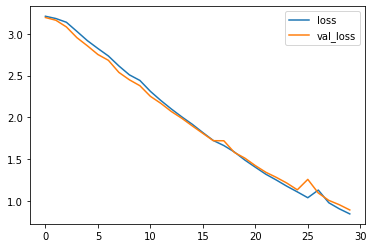

In [59]:
import matplotlib.pyplot as plt

plt.plot(r.history['loss'],label = 'loss')
plt.plot(r.history['val_loss'],label = 'val_loss')
plt.legend()

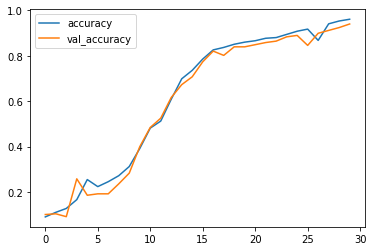

In [60]:
plt.plot(r.history['accuracy'],label = 'accuracy')
plt.plot(r.history['val_accuracy'],label = 'val_accuracy')
plt.legend()

# Conclusion
In this section of the project, an LSTM was used to classify the resumes.
Keras was used to create the model and the model was training on roughly 70% of the data with 30% left for testing. The model was able  to achieve training accuracy of 96.12% and a validation accuracy of 94.03%. The number of epochs that the model was trained on was 30. The overall accuracy of the model is lower compared to some of the other models that were tried in this project.

However, this is somewhat to be expected as more advanced models such as LSTM generally require to be trained on more data and require more hyper-parameter optmisation, to be made to work.